In [20]:
%matplotlib inline
import matplotlib.pyplot as plt
import sys
import scipy.io as sio
import os
import numpy as np

In [39]:
from sklearn.model_selection import cross_val_score
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, RobustScaler, Normalizer
from sklearn import preprocessing

In [22]:
clf_names = ["Nearest Neighbors", 
#              "Linear SVM", 
#              "RBF SVM", 
             "Gaussian Process",
             "Decision Tree", 
             "Random Forest", 
             "Neural Net", 
             "AdaBoost",
             "Naive Bayes", 
             "QDA"]
classifiers = [
    KNeighborsClassifier(3),
#     SVC(kernel="linear", C=0.025),
#     SVC(gamma=2, C=1),
    GaussianProcessClassifier(1.0 * RBF(1.0), warm_start=True),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    MLPClassifier(alpha=1),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis()]

In [23]:
def print_top_features(clf, top_k=10, feature_names = []):
    """Prints features with the highest coefficient values, per class"""
#     feature_names = vectorizer.get_feature_names()
    for i, class_label in enumerate(class_labels):
        print clf.coef_
        top_features_idx = np.argsort(clf.coef_[i])[-top_k:]
        if feature_names == []:
            print("{}:{}".format(class_label, top_features_idx))
        else:
            print("%s: %s" % (class_label,
                  " ".join(feature_names[j] for j in top_features_idx)))

In [24]:
def plot_important_features(features, clf, feature_name_list=[], num_selected_features=50):
    importances = clf.feature_importances_
    X = np.array(features)
    std = np.std([tree.feature_importances_ for tree in clf.estimators_],
                 axis=0)
    indices = np.argsort(importances)[::-1]

    # Print the feature ranking
    print("Feature ranking:")

    for f in range(0,num_selected_features):
        if feature_name_list == []:
            print("%d, (%f)" % (f + 1, importances[indices[f]]))
        else:
            print("%d. feature %s (%f)" % (f + 1, feature_name_list[indices[f]], importances[indices[f]]))

    # Plot the feature importances of the forest
    plt.figure()
    plt.title("Feature importances")
    plt.bar(range(num_selected_features), importances[indices[:num_selected_features]],
           color="r", yerr=std[indices[:num_selected_features]], align="center")
    plt.xticks(range(num_selected_features), indices[:num_selected_features])
    plt.xlim([-1, num_selected_features])
    plt.show()

In [49]:
def run_experiments(X, Y, feature_name_list=[], top_k=50):
    # iterate over classifiers
    '''
    print('Accuracy of different classifier, without Normalization')
    for name, clf in zip(clf_names, classifiers):
        scores = cross_val_score(clf, X, Y, cv=5)
        print("{}, {}/{}".format(name, np.mean(scores), np.std(scores)))
    
    adaboost_clf = AdaBoostClassifier()
    adaboost_clf.fit(X, Y)
    plot_important_features(X, adaboost_clf, feature_name_list, 50)
    '''
    
    print('Accuracy of different classifier, with Normalization')
    normalization_methods_name = ['StandardScaler', 'Normalizer']#, 'RobustScaler'
    normalization_methods = [StandardScaler(), Normalizer()]#, RobustScaler(),
    # iterate over classifiers
    for name, clf in zip(clf_names, classifiers):
        for norm_name, norm in zip(normalization_methods_name, normalization_methods):
            scores = cross_val_score((make_pipeline(norm, clf)), X, Y, cv=5)
            print("{},{}, {}/{}".format(name, norm_name, np.mean(scores), np.std(scores)))
    
    print('Scaled')
    X_scaled = preprocessing.scale(X)
#     scaled_adaboost_clf = make_pipeline(StandardScaler(), AdaBoostClassifier())
    clf = AdaBoostClassifier()
    clf.fit(X_scaled, Y)
    plot_important_features(X_scaled, clf, feature_name_list, top_k)
    
    print('Normalization')
    X_normalized =  preprocessing.normalize(X, norm='l2')
    clf = AdaBoostClassifier()
    clf.fit(X_normalized, Y)
    plot_important_features(X_normalized, clf, feature_name_list, top_k)

# prepare data into libsvm format

In [26]:
network_feature_name_file = '../aal_Conns.txt'
network_feature_name_list = []
with open(network_feature_name_file, 'r') as fin:
    network_feature_name_list = fin.read().split(',')
print len(network_feature_name_list), network_feature_name_list[0], type(network_feature_name_list)

4006 Precentral_L-Precentral_R <type 'list'>


In [27]:
label_file = '../data/controlAgeVol/gender.mat'
labels_mat = sio.loadmat(label_file)
key_to_extract = 'gender_withAgelVol'
ppl_id = labels_mat[key_to_extract][1:,0]
ppl_gender = labels_mat[key_to_extract][1:,1]
ppl_age = labels_mat[key_to_extract][1:,2]
ppl_whole_brain_volume = labels_mat[key_to_extract][1:,3]
print ppl_id.shape, ppl_gender.shape, ppl_age.shape

(402,) (402,) (402,)


Read label infomation

In [28]:
# Read label infomation
labels_dict = {}
num_positive = 0
num_negative = 0
for i in range(ppl_id.size):
    # label of this person is not provided
    if ppl_gender[i].size == 0:
        continue
    label_tmp = 0 if int(ppl_gender[i]) == 2 else 1
    if label_tmp == 0:
        num_negative += 1
    else:
        num_positive += 1
    labels_dict[str(ppl_id[i][0])] = label_tmp
print("Total:{}, Male:{}, Female:{}".format(num_negative+num_positive, num_positive, num_negative))    

Total:402, Male:168, Female:234


In [29]:
# Read age feature
age_dict = {}
for i in range(ppl_id.size):
#     print ppl_id[i][0], ppl_age[i]
    # skip without age information
    if ppl_age[i].size == 0:
        continue
    age_dict[ppl_id[i][0]] = ppl_age[i][0][0]
print('Length of with age feature: {}'.format(len(age_dict.keys())))

Length of with age feature: 394


In [30]:
# Read whole volume feature
whole_volume_dict = {}
for i in range(ppl_id.size):
    # skip without age information
    if ppl_whole_brain_volume[i].size == 0:
        print ppl_id[i][0], ppl_whole_brain_volume[i]
        continue
    whole_volume_dict[ppl_id[i][0]] = ppl_whole_brain_volume[i][0][0]
print('Length of with whole volume feature: {}'.format(len(whole_volume_dict.keys())))

Length of with whole volume feature: 402


In [31]:
# Read network feature
network_dict = {}
network_feature_path = '../data/controlAgeVol/network/'
for key in ppl_id:
    key = key[0]
    if os.path.isfile(os.path.join(network_feature_path, key+'.mat')):
        # Load feature mat file
        key_mat = sio.loadmat(os.path.join(network_feature_path, key+'.mat'))
        n,n = key_mat['Wauc'].shape
        # indices for upper matrix items without the diagonal items         
        upper_item_idx = np.triu_indices(n,1)
#         features.append(np.triu(key_mat['Wauc']).flatten().tolist())
        network_dict[key] = key_mat['Wauc'][upper_item_idx].tolist()        
    else:
        print key, ' is not in ', network_feature_path
print("Length of with network feature::{}".format(len(network_dict.keys())))

Length of with network feature::402


In [32]:
# Read volume feature
volume_dict = {}
volume_path = '../data/controlAgeVol/volume/'
for key in ppl_id:
    key = key[0]
    if os.path.isfile(os.path.join(volume_path, key+'.mat')):
        # Load feature mat file
        key_mat = sio.loadmat(os.path.join(volume_path, key+'.mat'))
#         print key_mat.keys(), key_mat['mri2atlas'].shape
        n,n = key_mat['mri2atlas'].shape
        # features.append(np.triu(key_mat['Wauc']).flatten().tolist())
        volume_dict[key] = key_mat['mri2atlas'].tolist()        
    else:
        print key, ' is not in ', volume_path
print("Length of with volume feature::{}".format(len(volume_dict.keys())))

Length of with volume feature::402


In [33]:
# Experiment with network, age, whole brain volume as features, gender as label
shared_ppl_ids = []
for ppl in labels_dict:
    if ppl in network_dict and ppl in age_dict and ppl in whole_volume_dict:
        shared_ppl_ids.append(ppl)
print("Number of shared ppl:{} ".format(len(shared_ppl_ids)))

Y1 = np.array([labels_dict[ppl] for ppl in shared_ppl_ids])
network_X = np.array([network_dict[ppl] for ppl in shared_ppl_ids])
age_X = np.array([age_dict[ppl] for ppl in shared_ppl_ids])
whole_volume_X = np.array([whole_volume_dict[ppl] for ppl in shared_ppl_ids])
print len(Y), network_X.shape, age_X.shape, whole_volume_X.shape
X1 = np.column_stack((network_X, age_X, whole_volume_X))
print Y1.shape, X1.shape

# build feature names
feature_name_list1 = list(network_feature_name_list)
feature_name_list1.append('age')
feature_name_list1.append('whole_volume')

Number of shared ppl:394 
394 (394, 4005) (394,) (394,)
(394,) (394, 4007)


In [45]:
# Experiment with network, age, whole brain volume as features, gender as label
shared_ppl_ids = []
for ppl in labels_dict:
    if ppl in volume_dict and ppl in age_dict and ppl in whole_volume_dict:
        shared_ppl_ids.append(ppl)
print("Number of shared ppl:{} ".format(len(shared_ppl_ids)))

Y2 = np.array([labels_dict[ppl] for ppl in shared_ppl_ids])
# network_X = np.array([network_dict[ppl] for ppl in shared_ppl_ids])
volume_X = np.array([volume_dict[ppl] for ppl in shared_ppl_ids])
age_X = np.array([age_dict[ppl] for ppl in shared_ppl_ids])
whole_volume_X = np.array([whole_volume_dict[ppl] for ppl in shared_ppl_ids])
print len(Y2), volume_X.shape, age_X.shape, whole_volume_X.shape
X2 = np.column_stack((volume_X.reshape(Y2.shape[0],-1), age_X, whole_volume_X))
print Y2.shape, X2.shape

# build feature names
feature_name_list2 = list([str(each) for each in range(volume_X.shape[0])])
feature_name_list2.append('age')
feature_name_list2.append('whole_volume')

Number of shared ppl:394 
394 (394, 90, 1) (394,) (394,)
(394,) (394, 92)


Accuracy of different classifier, with Normalization
Nearest Neighbors,StandardScaler, 0.59123661149/0.0432896981435
Nearest Neighbors,Normalizer, 0.654819863681/0.0666831301588
Gaussian Process,StandardScaler, 0.583771502759/0.00298604349237
Gaussian Process,Normalizer, 0.583771502759/0.00298604349237
Decision Tree,StandardScaler, 0.672314183707/0.0583105420527
Decision Tree,Normalizer, 0.685329438494/0.0445051558142
Random Forest,StandardScaler, 0.60405712431/0.0324047616061
Random Forest,Normalizer, 0.583771502759/0.00298604349237
Neural Net,StandardScaler, 0.621454073353/0.0848753570729
Neural Net,Normalizer, 0.583771502759/0.00298604349237
AdaBoost,StandardScaler, 0.763842908147/0.0247930650832
AdaBoost,Normalizer, 0.682700421941/0.0462521168137
Naive Bayes,StandardScaler, 0.519993508601/0.0800932092568
Naive Bayes,Normalizer, 0.558227848101/0.0397073092186
QDA,StandardScaler, 0.505095748134/0.0450090400604
QDA,Normalizer, 0.487244401168/0.0420417192276
Scaled
Feature ranking:
1. 

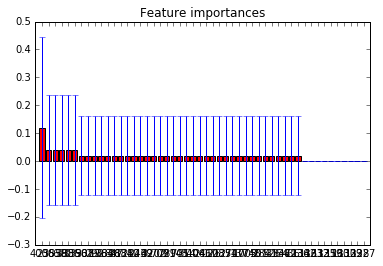

Normalization
Feature ranking:
1. feature  (0.160000)
2. feature Postcentral_R-Angular_R (0.020000)
3. feature Rectus_R-SupraMarginal_R (0.020000)
4. feature Precentral_R-Calcarine_L (0.020000)
5. feature Frontal_Sup_Orb_L-Occipital_Inf_R (0.020000)
6. feature Rolandic_Oper_R-Frontal_Med_Orb_L (0.020000)
7. feature Rolandic_Oper_R-Frontal_Med_Orb_R (0.020000)
8. feature Calcarine_L-Occipital_Sup_R (0.020000)
9. feature Calcarine_L-Occipital_Inf_L (0.020000)
10. feature Calcarine_L-Angular_L (0.020000)
11. feature Putamen_L-Temporal_Mid_R (0.020000)
12. feature Lingual_L-Angular_R (0.020000)
13. feature Frontal_Med_Orb_L-Precuneus_L (0.020000)
14. feature Supp_Motor_Area_R-Angular_L (0.020000)
15. feature Cingulum_Mid_R-Occipital_Mid_R (0.020000)
16. feature Fusiform_R-Parietal_Inf_L (0.020000)
17. feature Cuneus_R-Temporal_Sup_R (0.020000)
18. feature Calcarine_R-Occipital_Inf_L (0.020000)
19. feature Frontal_Sup_Orb_L-Occipital_Mid_L (0.020000)
20. feature Cingulum_Mid_L-Lingual_R (0.

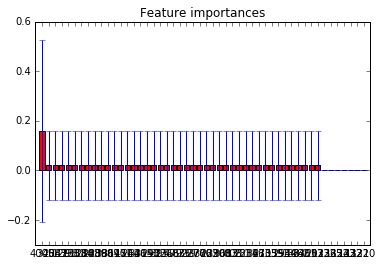

In [50]:
run_experiments(X1, Y1, feature_name_list1)

Accuracy of different classifier, with Normalization
Nearest Neighbors,StandardScaler, 0.710483609218/0.058457561029
Nearest Neighbors,Normalizer, 0.682635507952/0.0267067227089
Gaussian Process,StandardScaler, 0.705452775073/0.0581525730327
Gaussian Process,Normalizer, 0.583771502759/0.00298604349237
Decision Tree,StandardScaler, 0.725835767608/0.0212531611839
Decision Tree,Normalizer, 0.692827004219/0.0467117384071
Random Forest,StandardScaler, 0.753683868874/0.0529206691714
Random Forest,Normalizer, 0.583771502759/0.00298604349237
Neural Net,StandardScaler, 0.834923726063/0.0580802839297
Neural Net,Normalizer, 0.583771502759/0.00298604349237
AdaBoost,StandardScaler, 0.78653034729/0.0645789471204
AdaBoost,Normalizer, 0.685134696527/0.0512724365368
Naive Bayes,StandardScaler, 0.743557286595/0.0440392978111
Naive Bayes,Normalizer, 0.774066861409/0.020747205498
QDA,StandardScaler, 0.60159039273/0.0192188166861
QDA,Normalizer, 0.586303148328/0.0186401511161
Scaled
Feature ranking:
1. fea

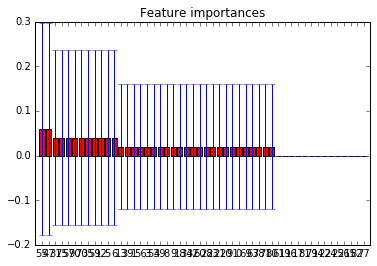

Normalization
Feature ranking:
1. feature 90 (0.980000)
2. feature 82 (0.020000)
3. feature 33 (0.000000)
4. feature 24 (0.000000)
5. feature 25 (0.000000)
6. feature 26 (0.000000)
7. feature 27 (0.000000)
8. feature 28 (0.000000)
9. feature 29 (0.000000)
10. feature 30 (0.000000)
11. feature 31 (0.000000)
12. feature 32 (0.000000)
13. feature 34 (0.000000)
14. feature 22 (0.000000)
15. feature 35 (0.000000)
16. feature 36 (0.000000)
17. feature 37 (0.000000)
18. feature 38 (0.000000)
19. feature 39 (0.000000)
20. feature 40 (0.000000)
21. feature 41 (0.000000)
22. feature 42 (0.000000)
23. feature 43 (0.000000)
24. feature 23 (0.000000)
25. feature 91 (0.000000)
26. feature 44 (0.000000)
27. feature 20 (0.000000)
28. feature 1 (0.000000)
29. feature 2 (0.000000)
30. feature 3 (0.000000)
31. feature 4 (0.000000)
32. feature 5 (0.000000)
33. feature 6 (0.000000)
34. feature 7 (0.000000)
35. feature 8 (0.000000)
36. feature 9 (0.000000)
37. feature 10 (0.000000)
38. feature 11 (0.000000)

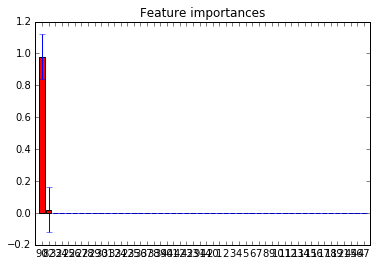

In [51]:
run_experiments(X2, Y2, feature_name_list2)